In [74]:
import os
import pandas as pd
import matplotlib.pyplot as plt
# 获取股票数据文件夹的路径
data_directory = '/Users/kai/Desktop/qs/data_csv_distinct_0606'
# 设置结果保存文件夹的路径
results_directory = '/Users/kai/Desktop/qs/data_csv_distinct_0606/__results'

In [176]:
filename = '000001.SZ.csv'
date = 24  # 横盘时间24周
alpha = 0.3  # 最大区间振幅30%
beta = 0.1  # 最大区间涨跌幅10%
fig_len = 100  # 画图长度

In [119]:
# 横盘判断

def find_sideways_movement(data, date:int, alpha, beta):
    """
    :param data: 股票数据
    :param date: 横盘区间的最短长度 单位：周
    :param alpha: 振幅阈值
    :param beta: 涨跌幅阈值
    """
    
    start_date = data.iloc[0]['TRADE_DT']
    end_date = start_date + pd.DateOffset(weeks=date)

    range_data = data[(data['TRADE_DT'] >= start_date)
                        & (data['TRADE_DT'] <= end_date)]
    high_price = range_data['S_DQ_HIGH'].max()
    low_price = range_data['S_DQ_LOW'].min()
    range_amplitude = (high_price - low_price) / low_price
    range_return = (range_data.iloc[-1]['S_DQ_CLOSE'] - range_data.iloc[0]
                    ['S_DQ_OPEN']) / range_data.iloc[0]['S_DQ_OPEN']

    if range_amplitude <= alpha and abs(range_return) <= beta:
        current_end_date = end_date
        while current_end_date < data.iloc[-1]['TRADE_DT']:
            current_end_date += pd.DateOffset(days=1)
            current_range_data = data[(data['TRADE_DT'] >= start_date) & (
                data['TRADE_DT'] <= current_end_date)]
            current_range_return = (
                current_range_data.iloc[-1]['S_DQ_CLOSE'] - current_range_data.iloc[0]['S_DQ_OPEN']) / current_range_data.iloc[0]['S_DQ_OPEN']
            current_high_price = current_range_data['S_DQ_HIGH'].max()
            current_low_price = current_range_data['S_DQ_LOW'].min()
            current_range_amplitude = (current_high_price - current_low_price) / current_low_price

            if abs(current_range_return) > beta or current_range_amplitude > alpha:
                end_date = current_end_date - \
                    pd.DateOffset(days=1)  # 结束日期更新为当前区间结束日期的前一天
                break #第一次超限就跳出循环，代表找到了第一个横盘

        # sideways_movement.append({
        #     'start_date': start_date,
        #     'end_date': current_end_date,
        #     'range_amplitude': range_amplitude,
        #     'range_return': range_return
        # })

        # start_date = current_end_date + \
        #     pd.DateOffset(days=1)  # 开始日期更新为当前区间结束日期的下一天
        # end_date = start_date + pd.DateOffset(weeks=8)  # 新的结束日期为开始日期后的八周
    # else:
    #     end_date += pd.DateOffset(days=1)  # 结束日期向后移动一天

    return (start_date, end_date)

In [114]:
# 可视化
def draw_peaks_and_valleys(peaks, valleys, df):

    print('peak ',len(peaks))
    print('valley ',len(valleys))
    # 获取最后100天的数据
    last_hundred_days_df = df.tail(fig_len)

    # 绘制折线图
    plt.plot(last_hundred_days_df['TRADE_DT'], last_hundred_days_df['S_DQ_CLOSE'], color='blue')


    # 将last_hundred_days_df['TRADE_DT']转换为与peaks中日期格式相同的字符串格式
    last_hundred_days_dates = last_hundred_days_df['TRADE_DT'].dt.strftime('%Y-%m-%d')
    # 提取最后100天内的峰值和谷值
    last_hundred_days_peaks = [peak for peak in peaks if peak['date'].strftime('%Y-%m-%d') in last_hundred_days_dates.values]
    last_hundred_days_valleys = [valley for valley in valleys if valley['date'].strftime('%Y-%m-%d') in last_hundred_days_dates.values]


    # 标记峰值和谷值
    for peak in last_hundred_days_peaks:
        plt.scatter(peak['date'], peak['price'], color='red', marker='^', label='Peak')
    for valley in last_hundred_days_valleys:
        plt.scatter(valley['date'], valley['price'], color='green', marker='v', label='Valley')

    # 设置图形标题和标签
    plt.title('Stock Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(['Stock Price', 'Peak', 'Valley'])

    # 显示图形
    plt.show()

peak  1354
valley  1365


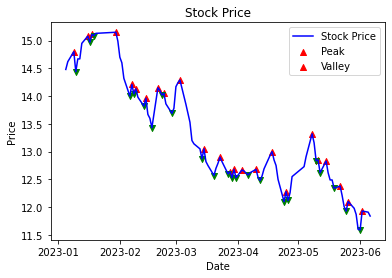

peak  1311
valley  1321


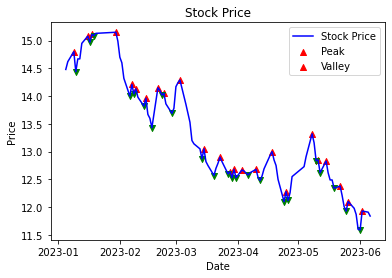

In [177]:
# 构建完整的文件路径


file_path = os.path.join(data_directory, filename)

# 读取数据并创建DataFrame
data = pd.read_csv(file_path)
df = pd.DataFrame(data)

# 转换日期列为日期时间类型
df['TRADE_DT'] = pd.to_datetime(df['TRADE_DT'], format='%Y%m%d')

# 按日期排序
df.sort_values('TRADE_DT', inplace=True)

# 初始化变量
peaks = []
valleys = []
peak_date = []
valley_date = []

# 找到峰值和谷值
for i in range(1, len(df) - 1):
    if df['S_DQ_CLOSE'][i] > df['S_DQ_CLOSE'][i-1] and df['S_DQ_CLOSE'][i] > df['S_DQ_CLOSE'][i+1]:
        peaks.append({'date': df['TRADE_DT'][i], 'price': df['S_DQ_CLOSE'][i], 'open': df['S_DQ_OPEN'][i]})
        peak_date.append(df['TRADE_DT'][i])
    elif df['S_DQ_CLOSE'][i] < df['S_DQ_CLOSE'][i-1] and df['S_DQ_CLOSE'][i] < df['S_DQ_CLOSE'][i+1]:
        valleys.append({'date': df['TRADE_DT'][i], 'price': df['S_DQ_CLOSE'][i], 'open': df['S_DQ_OPEN'][i]})
        valley_date.append(df['TRADE_DT'][i])

draw_peaks_and_valleys(peaks, valleys, df)
# 将peaks和valleys合并到一个dataframe中，并按照日期排序
peaks_and_valleys = pd.DataFrame(peaks + valleys)
peaks_and_valleys.sort_values('date', inplace=True)
peaks_and_valleys['date'] = pd.to_datetime(peaks_and_valleys['date'], format='%Y%m%d')
# 为peaks_and_valleys添加一列，用于计数
peaks_and_valleys['count'] = range(1, len(peaks_and_valleys) + 1)
# 找到符合条件：(后者price-前者open)/前者open>beta的相邻两者中的前者
i = 1
while True:
    count = len(peaks_and_valleys)
    b = (peaks_and_valleys[peaks_and_valleys['count']==i]['price'] - peaks_and_valleys[peaks_and_valleys['count']==i]['open']) / peaks_and_valleys[peaks_and_valleys['count']==i]['open']
    if b.values[0] < beta:
        start_date = peaks_and_valleys[peaks_and_valleys['count']==i]['date'].values[0]
        ddf = df[df['TRADE_DT'] >= start_date]
        (date_1,date_2) = find_sideways_movement(ddf, date, alpha, beta)
        # 移除peaks_and_valleys中位于date_1和date_2之间的元素
        peaks_and_valleys = peaks_and_valleys[((peaks_and_valleys['date'] <= date_1) | (peaks_and_valleys['date'] >= date_2))]
        # i等于peaks_and_valleys中大于等于date_2的最小count值
        i = peaks_and_valleys[peaks_and_valleys['date'] >= date_2]['count'].min()
        if ~i:
            break
    

# 通过匹配date相同，用现在的peaks_and_valleys还原peaks和valleys:
peaks = [x for x in peaks_and_valleys.to_dict('records') if x['date'] in peak_date]
valleys = [x for x in peaks_and_valleys.to_dict('records') if x['date'] in valley_date]
peaks.sort(key=lambda x: x['date'])
valleys.sort(key=lambda x: x['date'])

# 计算波动周期的时间间隔和涨幅
result_data = []
for i in range(len(valleys) - 1):
    valley_date = valleys[i]['date']
    valley_price = valleys[i]['price']
    next_valley_date = valleys[i+1]['date']
    next_valley_price = valleys[i+1]['price']
    
    # 寻找最高点价格
    highest_price = df[(df['TRADE_DT'] > valley_date) & (df['TRADE_DT'] < next_valley_date)]['S_DQ_CLOSE'].max()
    
    price_change = (highest_price - valley_price) / valley_price * 100
    interval = (next_valley_date - valley_date).days

    result_data.append({'波动周期起始日期': valley_date,
                        '波动周期终止日期': next_valley_date,
                        '最低点价格': valley_price,
                        '最高点价格': highest_price,
                        '涨幅': price_change,
                        '时间间隔（天）': interval})

# 将结果保存到CSV文件（指定编码为UTF-8）
output_filename = os.path.splitext(filename)[0] + '_result.csv'
output_file_path = os.path.join(results_directory, output_filename)
result_df = pd.DataFrame(result_data)
result_df.to_csv(output_file_path, index=False, encoding='utf-8-sig')

draw_peaks_and_valleys(peaks, valleys, df)
